# El modelo epidémico de SIR
Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

* S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
* I(t) es el número de individuos infecciosos;
* R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.

El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros,  beta y  gamma.  
- Beta describe la tasa de contacto efectiva de la enfermedad: un individuo infectado entra en contacto con  beta*N otros individuos por unidad de tiempo (de los cuales la fracción que es susceptible a contraer la enfermedad es S/N).  
- Gamma es la tasa de recuperación promedio: es decir, 1/ gamma es el período de tiempo promedio durante el cual una persona infectada puede transmitirlo.

Las ecuaciones diferenciales que describen este modelo fueron derivadas primero por Kermack y McKendrick [ Proc. R. Soc. A , 115 , 772 (1927)]:

\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\frac{\beta S I}{N},\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \frac{\beta S I}{N} - \gamma I,\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I.
\end{align*}

El siguiente código de Python integra estas ecuaciones para una enfermedad caracterizada por los parámetros  beta=0.2, gamma=10  en una población de N=1000 (quizás 'gripe en una escuela ) El modelo se inicia con una sola persona infectada el día 0: I(0)=1. Las curvas trazadas de S(t), I(t) y R(t) están diseñadas para verse un poco mejor que los valores predeterminados de Matplotlib.

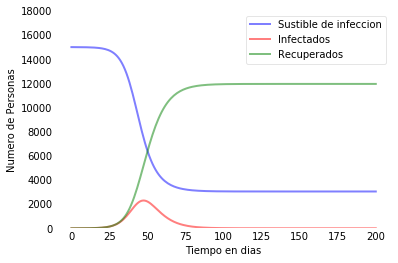

2.0


In [3]:
#Importar las librerias.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total de la poblacion
N = 15000
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = 0
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0
# Tasa de contacto, beta (nivel de repoductividad del virus) 
# La tasa de recuperación media, gamma,(1/días) Una persona se recupera en 15 dias.
beta, gamma = 0.4, 1.0/5 
# Una cuadrícula de puntos de tiempo (en días)
t = np.linspace(0, 200, 200)


# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Ro = beta/gamma
print(Ro)


## Generar la prediccion del modelos SIR

 Se debe  estimar el valor de 
- β 
- γ

Para ajustar el modelo SIR con los casos confirmados reales (el número de personas infecciosas) del Ecuador.
 
 Para ello deben seguir el siguiente tutorial 
 https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
 



Prediccion a ocho dias
S        1602.97
I           6575
R        8023.03
Date    04/30/20
Name: 50, dtype: object

country=Ecuador, beta=0.00001970, gamma=0.06863622, r_0:0.00028702


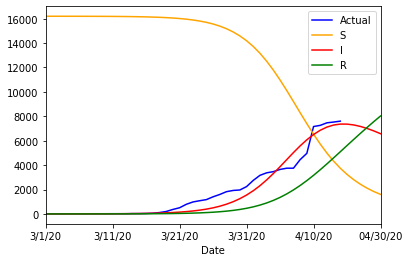

In [4]:
# Implementar y explicar la predicion del modelo SIR para el Ecuador

# 1. Implementar solo teniendo en cuenta los casos confirmados
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request
%matplotlib inline

class Confirmados(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0

    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        self.diaPrediccion = current + timedelta(days=16)
        print()
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        #print('valores', values)
        new_fecha = np.array(['4/18/20','4/19/20','4/20/20','4/21/20','4/22/20'])
        values = np.append(values,[new_fecha])
        values = np.append(values,datetime.strftime(self.diaPrediccion, '%m/%d/%y'))
        return values
    
    def predict(self, beta, gamma, data):
        predict_range = self.predict_range
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [self.s_0,self.i_0,self.r_0], t_eval=np.arange(0, size, 1))
    
    def train(self):
        data = self.load_confirmed(self.country)
        
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data, self.s_0, self.i_0, self.r_0),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2],
            'Date': new_index
        })
        print("Prediccion a ocho dias")
        predic = df.loc[:, ['S', 'I', 'R', 'Date']]
        print(predic.iloc[-1,:])
        print()
        ax = plt.gca()
        df.plot(kind='line',x='Date',y='Actual',color='blue', ax=ax)
        df.plot(kind='line',x='Date',y='S', color='orange', ax=ax)
        df.plot(kind='line',x='Date',y='I', color='red', ax=ax)
        df.plot(kind='line',x='Date',y='R', color='green', ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        
def loss(point, data, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

confirmados = Confirmados('Ecuador', loss, '3/1/20', 5, 16200, 1, 0)
confirmados.train()


Prediccion a 16 dias del Modelo SIR
Susceptible     2458.37
Infected          12362
Recovered       1380.62
Date           04/30/20
Name: 50, dtype: object

country=Ecuador, beta=0.00001480, gamma=0.01085656, r_0:0.00136321


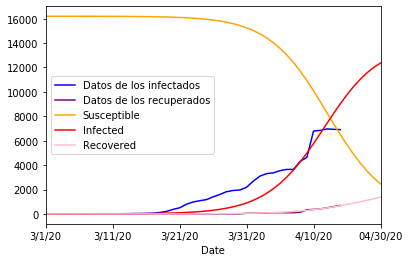

In [10]:
# 2. Implementar teniendo en cuenta los casos confirmados y recuperados.
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request
%matplotlib inline

class Recuperados(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        self.diaPrediccion = current + timedelta(days=16)
        print()
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        new_fecha = np.array(['4/18/20','4/19/20','4/20/20','4/21/20','4/22/20'])
        values = np.append(values,[new_fecha])
        values = np.append(values,datetime.strftime(self.diaPrediccion, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        data = (self.load_confirmed(self.country) - recovered)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, prediction = self.predict(beta, gamma, data, recovered, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Datos de los infectados': extended_actual, 
                           'Datos de los recuperados': extended_recovered, 
                           'Susceptible': prediction.y[0], 
                           'Infected': prediction.y[1], 
                           'Recovered': prediction.y[2],
                           'Date': new_index})
        print("Prediccion a 16 dias del Modelo SIR")
        predic = df.loc[:, ['Susceptible', 'Infected', 'Recovered', 'Date']]
        print(predic.iloc[-1,:])
        print()
        ax = plt.gca()
        df.plot(kind='line',x='Date',y='Datos de los infectados',color='blue', ax=ax)
        df.plot(kind='line',x='Date',y='Datos de los recuperados',color='purple', ax=ax)
        df.plot(kind='line',x='Date',y='Susceptible', color='orange', ax=ax)
        df.plot(kind='line',x='Date',y='Infected', color='red', ax=ax)
        df.plot(kind='line',x='Date',y='Recovered', color='pink', ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")

def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

recuperados = Recuperados('Ecuador', loss, '3/1/20', 5, 16200, 1, 0)
recuperados.train()


## Calculos de incidencia

Para obtener metricas de incidencia se debe calcular la tasa de prevalencia, incidencia y la relacion, para esto leer y obtener estos datos con la ultima lectura.

https://www.paho.org/hq/index.php?option=com_content&view=article&id=14402:indicadores-de-salud-aspectos-conceptuales-y-operativos-seccion-2&catid=9894&limitstart=2&Itemid=101&lang=es

In [14]:
# Implementar
#Lectura del csv de los casos confirmados a nivel mundial
url = ('https://covid.ourworldindata.org/data/ecdc/total_cases.csv')
df = pd.read_csv(url)

#Se llenan los campos vacios por 0
df = df.fillna(0)
df = df.loc[:,['Ecuador']] #Selecciono las columnas de analasis
df= df[df["Ecuador"] > 0.0] #Solo nos interesan los datos mayores a 0
nuevosCasos=df.iloc[-1]-df.iloc[-2] #Se resta el ultimo caso con el penultimo para obtener los nuevos casos
riesgo = df.iloc[-1] #Se seleccion la ultima cifra de los infectados, ya que el riesgo es la poblacion total
                     #menos los infectados
    
incidencia=((nuevosCasos[-1]/(17096789-riesgo[-1]))*pow(10,5))
prevalencia = ((riesgo[-1]/17096789))*pow(10,5)
relacion=(incidencia*(df.index[-1]-df.index[1]+1))

print('La tasa de incidencia es de',round(incidencia,2), 'por 100000 personas')
print('La tasa de prevalencia es de',round(prevalencia,2),'por 100000 personas')
print('La relacion es',round(relacion,2),'por 100000 personas')

La tasa de incidencia es de 0.37 por 100000 personas
La tasa de prevalencia es de 44.04 por 100000 personas
La relacion es 16.22 por 100000 personas


## Analisis
+ El modelo SIR es un modelo epidemiológico que captura las características que tienen los brotes epidémicos, donde S representa la población suseptible, I los infectados y R los recuperados.
+ El aplicar este modelo a la situación actual del país se puede tornar un poco compleja ya que los datos proporcionados no pueden ser los correctos y hablando en terminos de programacion puede ser que no se manejen muchas de las librerias como son pandas que ayuden a filtrar los datos de mejor manera y mas rapida.
+ Los valores de Beta y Gamma son valores clave para este modelo por lo que si no se tiene clara la formula para obtener estos valores se puede hacer uso de metodos que ya tiene python como es el minimize que permite obtener estos valores de forma rapida. 

## Conclusiones
+ Este modelo como podemos ver conjuntamente con los datos actuales que tenemos del pais si se ajusta a la linea de los casos actuales y de los recuperados pero se debe tener en cuenta que se trabaja con una poblacion menor a la que en realidad es la del Ecuador por tal razon no se puede confiar 100 por ciento y decir que este modelo predice lo que va a pasar, lo que si, nos ayuda a entender de como puede tornarse la situacion en el pais en dias posteriores, darnos una idea de lo que puede suceder.
+ Si se trabaja solo con datos de casos confirmados el valor de beta y gamma sera diferente si esque se hiciera uso tambien de recuperados y muertos, por eso se debe tomar en cuenta que se desea estimar para poder aplicar el beta y gamma respectivo.

## Opinion
+ En caso de que la prediccion de este modelo se torne real un poco o se siga apegando a la realidad del pais, debemos ser mas concientes, debemos acatar tanto las ordenes de prevension que da el gobierno como nosotros mismos poner mas orden para evitar que siga incrementando de forma exponencial y llegar a numeros que para la capacidad del pais son alarmantes y serian complejas de afrontarlas, el sistema de salud colapsaria.

# Referencias:
- https://www.agenciasinc.es/Reportajes/Un-modelo-un-teorema-y-teoria-de-juegos-contra-el-coronavirus
- https://rpubs.com/dsfernandez/422937
- https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2